# Fetal Classification

## Import necessary Libraries 

In [1]:
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
from IPython.display import Image
import imutils   

from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, classification_report

import keras
import tensorflow.keras as K

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator, array_to_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import imutils    

os.environ["CUDA_VISIBLE_DEVICES"] ="1"

## Data Visualization

In [2]:
#specify directory
train_dir = 'dir/'
test_dir = 'dir/'

In [3]:
#create classes
classes = os.listdir('dir/')

In [4]:
classes

['abnormal', 'normal']

In [5]:
files_path_dict = {}

for c in classes:
  files_path_dict[c] = list(map(lambda x: train_dir + c + '/' + x, os.listdir(train_dir + c)))

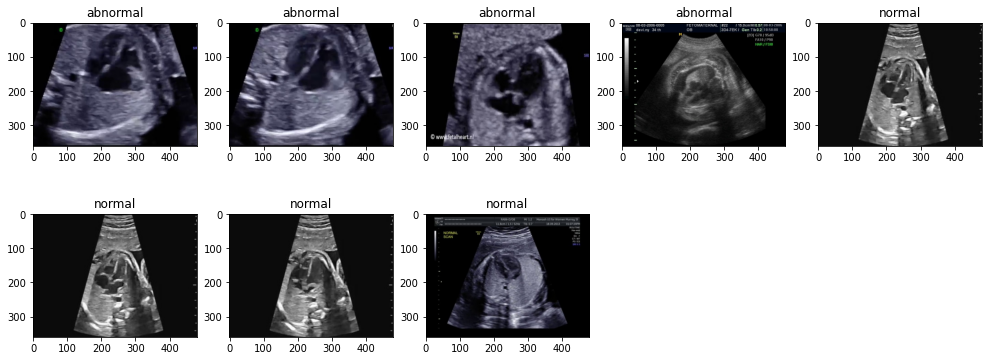

In [6]:
plt.figure(figsize = (17,17))
index = 0
for c in classes:
  random.shuffle(files_path_dict[c])
  path_list = files_path_dict[c][:5]

  for i in range(1, 5):
    index += 1
    plt.subplot(5, 5, index)
    plt.imshow(load_img(path_list[i]))
    plt.title(c)

## Data Augmentation

In [9]:
#use Image Data Generator to perform this task
#train set
datagen = ImageDataGenerator(rotation_range=10,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             validation_split=0.2)

train_data = datagen.flow_from_directory('dir/',
                                         target_size=(240, 240),
                                         batch_size=32,
                                         class_mode='categorical',
                                         subset='training')

valid_data = datagen.flow_from_directory('dir/',
                                         target_size=(240, 240),
                                         batch_size=32,
                                         class_mode='categorical',
                                         subset='validation')

#test set
test_datagen = ImageDataGenerator()

test_data = datagen.flow_from_directory('dir/',
                                         target_size=(240, 240),
                                        class_mode='categorical',
                                        shuffle=False)
                                        

Found 851 images belonging to 2 classes.
Found 52 images belonging to 2 classes.
Found 266 images belonging to 2 classes.


In [10]:
#view the class dictionary
print(train_data.class_indices)
print(test_data.class_indices)

{'abnormal': 0, 'normal': 1}
{'abnormal': 0, 'normal': 1}


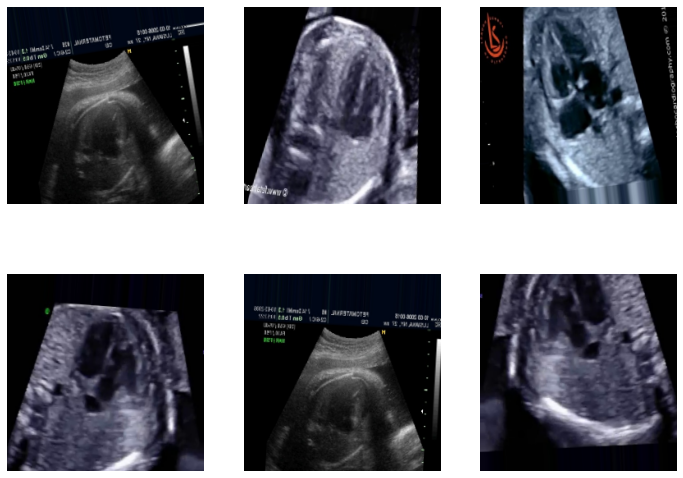

In [11]:
#view the augmented data
sample_x, sample_y = next(train_data)
plt.figure(figsize=(12, 9))
for i in range(6):
  plt.subplot(2, 3, i+1)
  sample = array_to_img(sample_x[i])
  plt.axis('off')
  plt.grid(False)
  plt.imshow(sample)
plt.show()

## Model Architect

In [16]:
#build the model
effnet = ResNet50(weights='imagenet', 
                        include_top=False, 
                        input_shape=None)

model = effnet.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(2, activation='softmax')(model)
model = Model(inputs=effnet.input, 
              outputs=model)

#get summary()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                         

## Compile Model

In [17]:
#compile model
model.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#define checkpoint
checkpoint = ModelCheckpoint('modelResNet50_2Class.h5', 
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='auto',
                             verbose=1)

#early stopping
earlystop = EarlyStopping(monitor='val_accuracy',
                          patience=5,
                          mode='auto',
                          verbose=1)

#reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', 
                              factor = 0.70, 
                              patience = 5, 
                              min_delta = 0.0001,
                              mode='auto',
                              verbose=1)

## Model Training and Model Evaluation

In [18]:
%%time

#train the model
history = model.fit(train_data,
                    epochs = 30,
                    validation_data=valid_data,
                    verbose=1,
                    callbacks=[checkpoint, reduce_lr])

Epoch 1/30
27/27 [==============================] - ETA: 0s - loss: 0.4792 - accuracy: 0.7732
Epoch 00001: val_accuracy improved from -inf to 0.53846, saving model to modelResNet50_2Class.h5


C:\Users\ISYSRG.COM\Anaconda3\envs\classgrad\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


27/27 [==============================] - 20s 541ms/step - loss: 0.4792 - accuracy: 0.7732 - val_loss: 1.1950 - val_accuracy: 0.5385 - lr: 0.0010
Epoch 2/30
27/27 [==============================] - ETA: 0s - loss: 0.1381 - accuracy: 0.9565
Epoch 00002: val_accuracy did not improve from 0.53846
27/27 [==============================] - 7s 270ms/step - loss: 0.1381 - accuracy: 0.9565 - val_loss: 0.9779 - val_accuracy: 0.5385 - lr: 0.0010
Epoch 3/30
27/27 [==============================] - ETA: 0s - loss: 0.0667 - accuracy: 0.9847
Epoch 00003: val_accuracy did not improve from 0.53846
27/27 [==============================] - 8s 280ms/step - loss: 0.0667 - accuracy: 0.9847 - val_loss: 0.7185 - val_accuracy: 0.5385 - lr: 0.0010
Epoch 4/30
27/27 [==============================] - ETA: 0s - loss: 0.0328 - accuracy: 0.9976
Epoch 00004: val_accuracy improved from 0.53846 to 0.55769, saving model to modelResNet50_2Class.h5
27/27 [==============================] - 10s 376ms/step - loss: 0.0328 - ac

Epoch 28/30
27/27 [==============================] - ETA: 0s - loss: 0.0037 - accuracy: 1.0000
Epoch 00028: val_accuracy did not improve from 1.00000
27/27 [==============================] - 8s 275ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.2447 - val_accuracy: 0.8846 - lr: 3.4300e-04
Epoch 29/30
27/27 [==============================] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000
Epoch 00029: val_accuracy did not improve from 1.00000

Epoch 00029: ReduceLROnPlateau reducing learning rate to 0.00024009999469853935.
27/27 [==============================] - 8s 281ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.2053 - val_accuracy: 0.9231 - lr: 3.4300e-04
Epoch 30/30
27/27 [==============================] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000
Epoch 00030: val_accuracy did not improve from 1.00000
27/27 [==============================] - 8s 275ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.1502 - val_accuracy: 0.9423 - lr: 2.4010e-04
Wall time: 4min 22s


In [19]:
hist_df = pd.DataFrame(history.history) 
# save to json:  
hist_json_file = 'history_2Class_ResNet50.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# or save to csv: 
hist_csv_file = 'history_2Class_ResNet50.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

## Model Evaluation

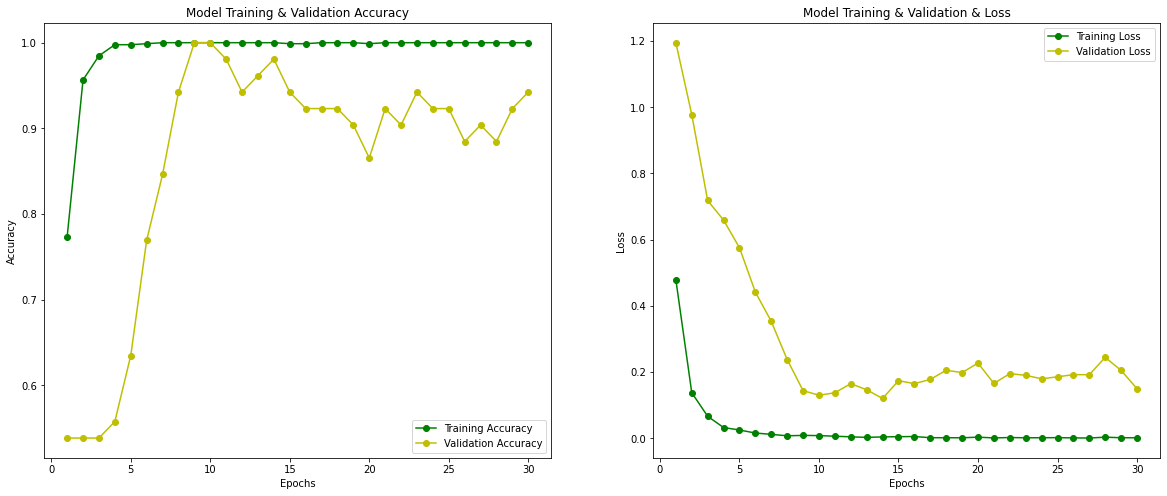

In [20]:
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20, 8)

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

ax[0].plot(epochs , train_acc , 'g-o' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'y-o' , label = 'Validation Accuracy')
ax[0].set_title('Model Training & Validation Accuracy')
ax[0].legend(loc = 'lower right')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'y-o' , label = 'Validation Loss')
ax[1].set_title('Model Training & Validation & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()

In [22]:
print('Train accuracy & loss:', model.evaluate(train_data))
print('\n')
print('Test accuracy & loss:', model.evaluate(test_data))

27/27 [==============================] - 7s 255ms/step - loss: 2.6172e-04 - accuracy: 1.0000
Train accuracy & loss: [0.0002617176796775311, 1.0]


9/9 [==============================] - 6s 732ms/step - loss: 0.0374 - accuracy: 0.9925
Test accuracy & loss: [0.03740530088543892, 0.9924812316894531]


In [23]:
#define labels for testing
y_test = test_data.classes

#make prediction
yhat_test = np.argmax(model.predict(test_data), axis=1)

In [24]:
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

In [25]:
yhat_test

array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1], dtype=int64)

In [26]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion Matrix',
                          cmap = plt.cm.Blues):
    
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 fontsize = 12,
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

[[138   5]
 [  0 123]]


C:\Users\ISYSRG.COM\Anaconda3\envs\classgrad\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  # Remove the CWD from sys.path while we load stuff.


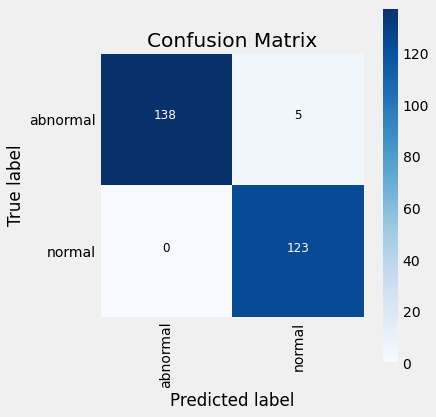

In [27]:
#get confusion matrix
cm = confusion_matrix(y_test, yhat_test)
print(cm)

#plot
plot_confusion_matrix(cm, classes, normalize=False)

In [28]:
#get classification report
print(classification_report(y_test, yhat_test))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       143
           1       0.96      1.00      0.98       123

    accuracy                           0.98       266
   macro avg       0.98      0.98      0.98       266
weighted avg       0.98      0.98      0.98       266



## Obtaining Predictions on Test Images

In [29]:
import PIL

class_dict = {0: 'asd',
              1: 'avsd',
              2: 'normal',
              3: 'tof',
              4: 'vsd'}
              
prediction = []
original = []
image = []
count = 0
for i in os.listdir('dir/'):
  for item in os.listdir(os.path.join('dir/', i)):
    # code to open the image
    img= PIL.Image.open(os.path.join('dir', i, item))
    #append to image list
    image.append(img)
    #expand dimension
    img = np.expand_dims(img, axis=0)
    #predict
    predict = model.predict(img)
    #get the index corresponding to the highest value in the prediction
    predict = np.argmax(predict)
    #append the predicted class to the list
    prediction.append(class_dict[predict])
    #append original class to the list
    original.append(i)

In [30]:
#test accuracy 
score = accuracy_score(original, prediction)
print("Test Accuracy : {}".format(score))

Test Accuracy : 0.0


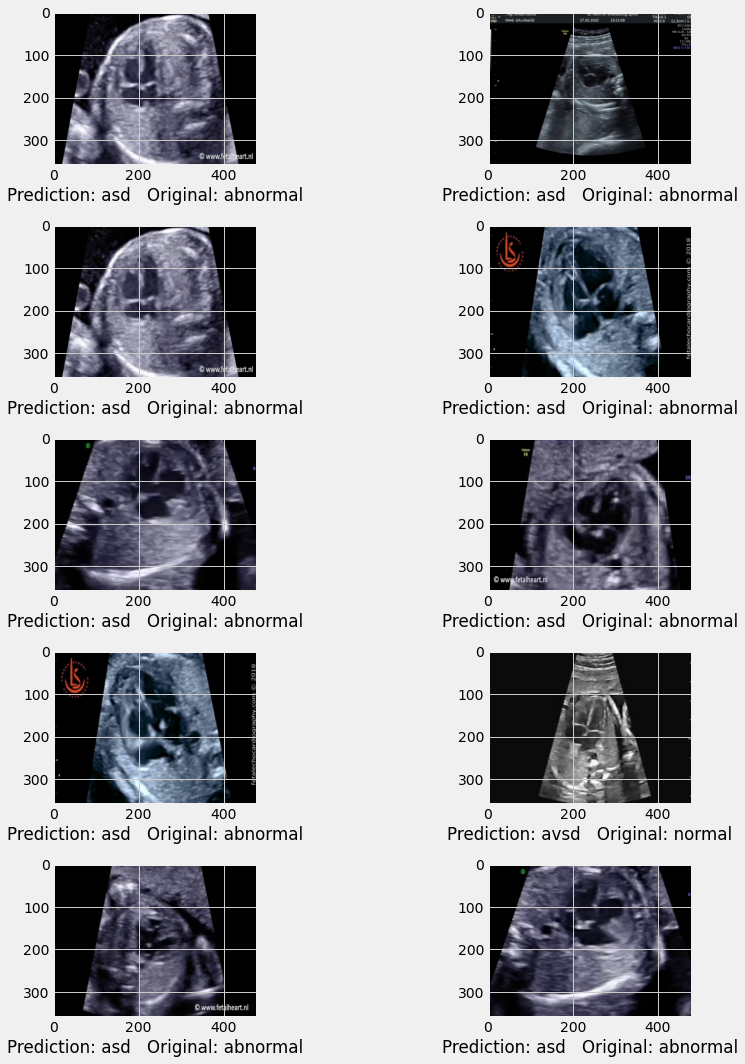

In [31]:
#visualize the results
fig = plt.figure(figsize = (15, 15))
for i in range(10):
    j = random.randint(0, len(image))
    fig.add_subplot(5, 2, i+1)
    plt.xlabel("Prediction: " + prediction[j] +"   Original: " + original[j])
    plt.imshow(image[j])
fig.tight_layout()
plt.show()